In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [2]:
# attach the column names to the dataset
columns_name = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [3]:
# load the dataset to the model
df = pd.read_csv("KDDTrain+_2.csv", header=None, names=columns_name)
df_test = pd.read_csv("KDDTest+_2.csv", header=None, names=columns_name)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
print("Train Dataset:")
for columns_name in df.columns:
    if df[columns_name].dtypes == 'object' :
        columns_count = len(df[columns_name].unique())
        print("Feature '{columns_name}' has {columns_count}".format(columns_name = columns_name, columns_count = columns_count))

print("")

print("Test Dataset:")
for columns_name in df_test.columns:
    if df_test[columns_name].dtypes == 'object' :
        columns_count = len(df_test[columns_name].unique())
        print("Feature '{columns_name}' has {columns_count}".format(columns_name = columns_name, columns_count= columns_count))

Train Dataset:
Feature 'protocol_type' has 3
Feature 'service' has 66
Feature 'flag' has 11
Feature 'label' has 22

Test Dataset:
Feature 'protocol_type' has 3
Feature 'service' has 64
Feature 'flag' has 11
Feature 'label' has 38


In [5]:
categorical_columns = ['protocol_type', 'service', 'flag']

# Represent Categorical columns in 2D numpy 
df_categorical_columns = df[categorical_columns]
df_test_categorical_columns = df_test[categorical_columns]
df_categorical_columns.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [6]:

cat_protocol = sorted(df.protocol_type.unique())
string1 = 'protocol_type_'
cat_protocol2 = [string1 + x for x in cat_protocol]

cat_service = sorted(df.service.unique())
string2 = 'service_'
cat_service2 = [string2 + x for x in cat_service]

cat_flag = sorted(df.flag.unique())
string3 = 'flag_'
cat_flag2 = [string3 + x for x in cat_flag]

dummy_cols = cat_protocol2 + cat_service2 + cat_flag2 

cat_service_test = sorted(df_test.service.unique())
cat_service_test2 = [string2 + x for x in cat_service_test]

testdummy_cols = cat_protocol2 + cat_service_test2 + cat_flag2

print(dummy_cols)

['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_hostnames', 'service_http', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'service_rje', 'service_shell', 'service_smtp', 'service_sql

In [7]:
# onehotencoding to change categorical data to numeric
enc = OneHotEncoder()

# Encoding train set
df_cat_cols = enc.fit_transform(df_categorical_columns)
df_encoded_cols = pd.DataFrame(df_cat_cols.toarray(), columns = dummy_cols)

# Encoding test set
df_test_cat_cols = enc.fit_transform(df_test_categorical_columns)
df_test_encoded_cols = pd.DataFrame(df_test_cat_cols.toarray(), columns = testdummy_cols)

df_encoded_cols.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
train_service = df['service'].tolist()
test_service = df_test['service'].tolist()
trainnew = list(set(train_service) - set(test_service))
trainnew_service = [string2 + x for x in trainnew]
trainnew_service

['service_http_8001', 'service_urh_i', 'service_red_i']

In [9]:
for col in trainnew_service:
    df_test_encoded_cols[col] = 0
df_test_encoded_cols.shape

(22544, 81)

In [10]:
# Updating train dataset by replacing old non-numeric column with encoded numeric columns
new_df = df.join(df_encoded_cols)
new_df.drop('protocol_type', axis = 1, inplace = True)
new_df.drop('service', axis = 1, inplace = True)
new_df.drop('flag', axis = 1, inplace =True)

# Updating test dataset
new_df_test = df_test.join(df_test_encoded_cols)
new_df_test.drop('protocol_type', axis = 1, inplace = True)
new_df_test.drop('service', axis = 1, inplace = True)
new_df_test.drop('flag', axis = 1, inplace = True)

print(new_df.shape)
print(new_df_test.shape)

new_df.head()

(25192, 119)
(22544, 120)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# take label column
labeldf=new_df['label']
labeldf_test=new_df_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 1,'nmap' : 1,'portsweep' : 1,'satan' : 1,'mscan' : 1,'saint' : 1
                           ,'ftp_write': 1,'guess_passwd': 1,'imap': 1,'multihop': 1,'phf': 1,'spy': 1,'warezclient': 1,'warezmaster': 1,'sendmail': 1,'named': 1,'snmpgetattack': 1,'snmpguess': 1,'xlock': 1,'xsnoop': 1,'httptunnel': 1,
                           'buffer_overflow': 1,'loadmodule': 1,'perl': 1,'rootkit': 1,'ps': 1,'sqlattack': 1,'xterm': 1})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 1,'nmap' : 1,'portsweep' : 1,'satan' : 1,'mscan' : 1,'saint' : 1
                           ,'ftp_write': 1,'guess_passwd': 1,'imap': 1,'multihop': 1,'phf': 1,'spy': 1,'warezclient': 1,'warezmaster': 1,'sendmail': 1,'named': 1,'snmpgetattack': 1,'snmpguess': 1,'xlock': 1,'xsnoop': 1,'httptunnel': 1,
                           'buffer_overflow': 1,'loadmodule': 1,'perl': 1,'rootkit': 1,'ps': 1,'sqlattack': 1,'xterm': 1})
# put the new label column back
new_df['label'] = newlabeldf
new_df_test['label'] = newlabeldf_test
print(new_df['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [12]:
# Splitting data such that one part has features and other part has only label in numeric

# Train set
X_Label = new_df.drop('label', 1)
Y_Label = new_df.label

# Test set
X_Label_test = new_df_test.drop('label', 1)
Y = new_df_test.label

X_Label.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
Y_Label.head()

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [14]:
new_cols = list(X_Label)
new_cols_test = list(X_Label_test)
print(new_cols)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', '

In [15]:
# Fitting the Recursive Feature Elimination techinque to the dataset for feature selection
clf = RandomForestClassifier(n_estimators = 100, n_jobs = -2)
rfe_clf = RFE(estimator = clf, n_features_to_select = 9, step = 1)
lab_enc = preprocessing.LabelEncoder()
Y_Label_enc = lab_enc.fit_transform(Y_Label)
rfe_clf.fit(X_Label, Y_Label_enc)
X_Label_rfe = rfe_clf.transform(X_Label)
true = rfe_clf.support_
rfe_label = [i for i, x in enumerate(true) if x]
rfe_cols = list(new_cols[i] for i in rfe_label)


In [16]:
rfe_clf.ranking_

array([ 23,   1,   1,  65,  26,  56,  10,  43,   5,  17,  46,  54,  38,
        42,  61,  47, 105, 110,  32,   1,   4,  16,  12,  25,  27,   1,
         1,  29,   8,   1,   1,   3,   1,   6,  18,   9,  11,  21,   2,
        14,  20,  44,  51,  86,  45,  98,  85,  93,  72,  69,  87,  73,
        31, 109,  22,   7, 103, 100,  40,  30,  19,  58,  96,  13,  77,
       107,  48,  83,  95, 102,  89,  79,  76,  68,  88,  92,  84,  81,
        99,  94,  74,  64,  33,  49, 106,  66, 108,  15,  63,  97, 104,
        71,  37,  82,  52,  90,  80,  91,  36,  55,  50,  60,  35,  70,
        78, 101,  75,  59,  34,  41,  62,  28,  24,  39,  57,  67,   1,
        53])

In [17]:
print('Selected Features :', rfe_cols)

Selected Features : ['src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'flag_SF']


In [18]:
mod = RandomForestClassifier(n_estimators = 100, n_jobs = -2)
mod.fit(X_Label_rfe, Y_Label_enc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-2, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [19]:
# Replace test datasets according to the selected datasets
x = X_Label_test.iloc[:, rfe_label]

In [20]:
# Predict the selected dataset with classifier
Y_Label_pred = mod.predict(x)

# Creating a Confusion Matrix
pd.crosstab(Y, Y_Label_pred, rownames = ['Actual attacks'], colnames = ['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9445,266
1,4988,7845


In [25]:
accuracy = cross_val_score(mod, x, Y, cv = 10, scoring = 'accuracy')
print("Accuracy: %2f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(mod, x, Y, cv = 10, scoring = 'precision_micro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(mod, x, Y, cv = 10, scoring = 'recall_micro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
fmeasure = cross_val_score(mod, x, Y, cv = 10, scoring = 'f1_micro')
print("F-measure: %0.5f (+/- %0.5f)" % (fmeasure.mean(), fmeasure.std() * 2))

Accuracy: 0.982656 (+/- 0.00383)
Precision: 0.98208 (+/- 0.00397)


KeyboardInterrupt: 

Automatically created module for IPython interactive environment


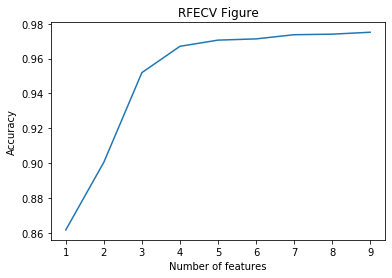

In [43]:
print(__doc__)
import matplotlib.pyplot as plt
rfecv_label = RFECV(estimator = mod, step = 1, cv =10, scoring = 'accuracy')
rfecv_label.fit(x, Y)

plt.figure()
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("RFECV Figure")
plt.plot(range(1, len(rfecv_label.grid_scores_) + 1), rfecv_label.grid_scores_)
plt.show()

In [1]:
import pickle


In [2]:
model = RandomForestClassifier(n_estimators = 100, n_jobs = -2)
model.fit(x, Y)
pickle.dump(model, open('save_model.pkl', 'wb'))

NameError: name 'RandomForestClassifier' is not defined

In [3]:
load_model = pickle.load(open('save_model.pkl', 'rb'))
score = load_model.score(x, Y)
print(score)

NameError: name 'x' is not defined

In [4]:
import socket, subprocess

In [5]:
cmd = "/root/build-files/src/kdd99extractor"

In [6]:
process = subprocess.Popen(cmd, stdout = subprocess.PIPE, stderr = subprocess.STDOUT)

In [7]:
load_model = pickle.load(open('save_model.pkl', 'rb'))
for line in iter(process.stdout.readline, b""):
    line = line.strip()
    columns = str(line)
    columns = columns.replace("b'", "")
    columns = columns.replace("'", "")
   # print(columns)
    if "icmp" in columns:
        columns = columns.replace("icmp","1.0")
    if "tcp" in columns:
        columns = columns.replace("tcp","0.0")
    if "udp" in columns:
        columns = columns.replace("udp","0.0")
    if "SF" in columns:
        columns = columns.replace("SF","1.0")
    if "OTH" in columns:
        columns = columns.replace("OTH","0.0")
    if "REJ" in columns:
        columns = columns.replace("REJ","0.0")
    if "RSTO" in columns:
        columns = columns.replace("RSTO","0.0")
    if "RSTOS0" in columns:
        columns = columns.replace("RSTOS0","0.0")
    if "RSTR" in columns:
        columns = columns.replace("RSTR","0.0")
    if "S0" in columns:
        columns = columns.replace("S0","0.0")
    if "S1" in columns:
        columns = columns.replace("S1","0.0")
    if "S2" in columns:
        columns = columns.replace("S2","0.0")
    if "S3" in columns:
        columns = columns.replace("S3","0.0")
    if "SH" in columns:
        columns = columns.replace("SH","0.0")
    if "http_443," in columns:
        columns = columns.replace("http_443","0.0")
    if "other," in columns:
        columns = columns.replace("other","0.0")
    if "private," in columns:
        columns = columns.replace("private","0.0")
    if "http," in columns:
        columns = columns.replace("http","0.0")
    if "domain_u," in columns:
        columns = columns.replace("domain_u","0.0")
    lis = columns[0:113]
   # print(lis)
    test_list  = [float(x) for x in lis.split(',')]
    index_list = [4, 5, 9, 15, 16, 21, 22, 24, 3]  
    #index_list = [7, 8, 12, 23, 25, 30, 33, 35, 5]  
    res_list = [test_list[i] for i in index_list] 
    fin = [np.array(res_list)]
    test = load_model.predict(fin)
    if test == 0:
        test = "Normal"
    else:
        test = "Malicious"
    print(test)

 
        


NameError: name 'np' is not defined